## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

# **New York City Yellow Taxi Data**

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [2]:
# Import warnings

# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Import the libraries you will be using for analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime


In [ ]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [ ]:
# Try loading one file
file_path = "D:/EDA-Exploratary Assignments/Data/yellow_tripdata_2023-01.parquet"
df = pd.read_parquet(file_path)
df.info()

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [ ]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import os
import pandas as pd
# Set the directory containing the Parquet files
os.chdir(r'D:/EDA-Exploratary Assignments/Data')

# List all Parquet files
file_list = [f for f in os.listdir() if f.endswith('.parquet')]

# Initialize an empty DataFrame for combined data
df = pd.DataFrame()

# Sampling fraction
sample_fraction = 0.05

# Iterate through each file
for file_name in file_list:
    try:
        # Read the Parquet file
        file_path = os.path.join(os.getcwd(), file_name)
        month_df = pd.read_parquet(file_path)
        
        # Extract date and hour from tpep_pickup_datetime
        month_df['pickup_date'] = month_df['tpep_pickup_datetime'].dt.date
        month_df['pickup_hour'] = month_df['tpep_pickup_datetime'].dt.hour
        
        # Initialize an empty DataFrame for sampled data
        sampled_data = pd.DataFrame()
        
        # Group by date and hour
        for date in month_df['pickup_date'].unique():
            for hour in range(24):
                # Filter data for the specific date and hour
                hour_data = month_df[(month_df['pickup_date'] == date) & 
                                   (month_df['pickup_hour'] == hour)]
                
                # Sample 5% of the data
                if not hour_data.empty:
                    sample = hour_data.sample(frac=sample_fraction, random_state=42)
                    sampled_data = pd.concat([sampled_data, sample])
        
        # Append sampled data to the main DataFrame
        df = pd.concat([df, sampled_data])
        
        print(f"Processed {file_name}")
        
    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

# Drop temporary columns
df = df.drop(['pickup_date', 'pickup_hour'], axis=1)

# Reset index
df = df.reset_index(drop=True)


# Check the number of rows
print(f"Total rows in combined DataFrame: {len(df)}")
df.to_parquet('D:/EDA-Exploratary Assignments/Data/combined_2023_taxi_data.parquet')

In [6]:
# Save the combined DataFrame to a Parquet file

df = pd.read_parquet('D:/EDA-Exploratary Assignments/Data/combined_2023_taxi_data.parquet')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915511 entries, 0 to 1915510
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:10:30   2023-01-01 00:11:49              1.0   
1         2  2023-01-01 00:49:02   2023-01-01 00:55:15              1.0   
2         1  2023-01-01 00:47:17   2023-01-01 01:07:01              2.0   
3         2  2023-01-01 00:06:02   2023-01-01 00:31:38              1.0   
4         2  2023-01-01 00:02:19   2023-01-01 00:30:49              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           0.49         1.0                  N           239           238   
1           0.75         1.0                  N            45           148   
2           2.90         1.0                  N           142           170   
3           2.50         1.0                  N            43           161   
4          20.37         2.0                  N           132           140   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1          4.4    1.0      0.5        1.88          0.00   
1             2          7.9    1.0      0.5        0.00          0.00   
2             1         19.1    3.5      0.5        4.80          0.00   
3             1         24.0    1.0      0.5        7.25          0.00   
4             1         70.0    0.0      0.5       12.00          6.55   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  \
0                    1.0         11.28                   2.5          0.0   
1                    1.0         12.90                   2.5          0.0   
2                    1.0         28.90                   2.5          0.0   
3                    1.0         36.25                   2.5          0.0   
4                    1.0         92.55                   2.5          0.0   

   Airport_fee  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [ ]:
After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [ ]:
# Store the df in csv/parquet
df.to_parquet('/content/Assignments/EDA/data_NYC_Taxi/combined_2023_taxi_data.parquet')

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [ ]:
# Load the new data file

df = pd.read_parquet('D:/EDA-Exploratary Assignments/Data/combined_2023_taxi_data.parquet')

In [7]:
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:10:30   2023-01-01 00:11:49              1.0   
1         2  2023-01-01 00:49:02   2023-01-01 00:55:15              1.0   
2         1  2023-01-01 00:47:17   2023-01-01 01:07:01              2.0   
3         2  2023-01-01 00:06:02   2023-01-01 00:31:38              1.0   
4         2  2023-01-01 00:02:19   2023-01-01 00:30:49              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           0.49         1.0                  N           239           238   
1           0.75         1.0                  N            45           148   
2           2.90         1.0                  N           142           170   
3           2.50         1.0                  N            43           161   
4          20.37         2.0                  N           132           140   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1          4.4    1.0      0.5        1.88          0.00   
1             2          7.9    1.0      0.5        0.00          0.00   
2             1         19.1    3.5      0.5        4.80          0.00   
3             1         24.0    1.0      0.5        7.25          0.00   
4             1         70.0    0.0      0.5       12.00          6.55   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  \
0                    1.0         11.28                   2.5          0.0   
1                    1.0         12.90                   2.5          0.0   
2                    1.0         28.90                   2.5          0.0   
3                    1.0         36.25                   2.5          0.0   
4                    1.0         92.55                   2.5          0.0   

   Airport_fee  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915511 entries, 0 to 1915510
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [9]:
# Fix the index and drop any columns that are not needed
# Reset the index
df = df.reset_index(drop=True)

# Drop 'store_and_fwd_flag' as it’s not relevant for analysis
df = df.drop('store_and_fwd_flag', axis=1, errors='ignore')

# Verify columns
print(df.columns)


Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'airport_fee', 'Airport_fee'],
      dtype='object')


**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [10]:
# Combine the two airport fee columns
# Check for airport fee columns
airport_columns = [col for col in df.columns if 'airport' in col.lower()]
print("Airport-related columns:", airport_columns)

# Combine airport fee columns if both exist
if len(airport_columns) > 1:
    df['airport_fee'] = df[airport_columns].sum(axis=1, min_count=1)
    df = df.drop([col for col in airport_columns if col != 'airport_fee'], axis=1)
elif len(airport_columns) == 1:
    df['airport_fee'] = df[airport_columns[0]]
else:
    print("No airport fee columns found.")

# Verify the result
print(df['airport_fee'].describe())


Airport-related columns: ['airport_fee', 'Airport_fee']
count    1.850371e+06
mean     1.393217e-01
std      4.672190e-01
min     -1.750000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.750000e+00
Name: airport_fee, dtype: float64


**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [11]:
# check where values of fare amount are negative

# Identify monetary columns
monetary_columns = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 
                    'total_amount', 'congestion_surcharge', 'airport_fee', 'improvement_surcharge']

# Check for negative values
for col in monetary_columns:
    if col in df.columns:
        negative_count = (df[col] < 0).sum()
        print(f"Negative values in {col}: {negative_count}")

# Analyze RatecodeID for negative fare_amount
negative_fares = df[df['fare_amount'] < 0]
print("RatecodeID distribution for negative fares:")
print(negative_fares['RatecodeID'].value_counts())

# Handle negative values
for col in monetary_columns:
    if col in df.columns:
        # Replace negative values with NaN for later imputation
        df.loc[df[col] < 0, col] = np.nan

# Impute NaN values with median for monetary columns
for col in monetary_columns:
    if col in df.columns:
        median_value = df[col].median()
        df[col] = df[col].fillna(median_value)

# Verify no negative values remain
for col in monetary_columns:
    if col in df.columns:
        print(f"Negative values in {col} after cleaning: {(df[col] < 0).sum()}")

Negative values in fare_amount: 19056
Negative values in extra: 9472
Negative values in mta_tax: 18241
Negative values in tip_amount: 117
Negative values in tolls_amount: 1203
Negative values in total_amount: 18840
Negative values in congestion_surcharge: 15051
Negative values in airport_fee: 2436
Negative values in improvement_surcharge: 18829
RatecodeID distribution for negative fares:
RatecodeID
1.0    16721
2.0     1324
5.0      369
3.0      223
4.0       88
Name: count, dtype: int64


NameError: name 'np' is not defined

Did you notice something different in the `RatecodeID` column for above records?

In [ ]:
# Analyse RatecodeID for the negative fare amounts



In [ ]:
# Find which columns have negative values



In [ ]:
# fix these negative values



### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [12]:
# Find the proportion of missing values in each column

# Calculate proportion of missing values
missing_proportions = df.isna().mean()
print("Proportion of missing values per column:")
print(missing_proportions)

Proportion of missing values per column:
VendorID                 0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          0.034007
trip_distance            0.000000
RatecodeID               0.034007
PULocationID             0.000000
DOLocationID             0.000000
payment_type             0.000000
fare_amount              0.000000
extra                    0.000000
mta_tax                  0.000000
tip_amount               0.000000
tolls_amount             0.000000
improvement_surcharge    0.000000
total_amount             0.000000
congestion_surcharge     0.034007
airport_fee              0.034007
dtype: float64


**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [14]:
import numpy as np
# Display the rows with null values
# Impute NaN values in 'passenger_count'
# Display rows with missing passenger_count
print("Rows with missing passenger_count:", df['passenger_count'].isna().sum())

# Check for zero passenger_count
print("Rows with zero passenger_count:", (df['passenger_count'] == 0).sum())

# Impute missing and zero passenger_count with median
median_passengers = df[df['passenger_count'] > 0]['passenger_count'].median()
df['passenger_count'] = df['passenger_count'].replace(0, np.nan)
df['passenger_count'] = df['passenger_count'].fillna(median_passengers)

# Verify
print("Missing passenger_count after imputation:", df['passenger_count'].isna().sum())
print("Zero passenger_count after imputation:", (df['passenger_count'] == 0).sum())


Rows with missing passenger_count: 65140
Rows with zero passenger_count: 29587
Missing passenger_count after imputation: 0
Zero passenger_count after imputation: 0


Did you find zeroes in passenger_count? Handle these.

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [15]:
# Fix missing values in 'RatecodeID'
# Check missing RatecodeID
print("Missing RatecodeID:", df['RatecodeID'].isna().sum())

# Impute with mode (most frequent RatecodeID, likely 1=Standard rate)
mode_ratecode = df['RatecodeID'].mode()[0]
df['RatecodeID'] = df['RatecodeID'].fillna(mode_ratecode)

# Verify
print("Missing RatecodeID after imputation:", df['RatecodeID'].isna().sum())

Missing RatecodeID: 65140
Missing RatecodeID after imputation: 0


**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [16]:
# handle null values in congestion_surcharge
# Check missing congestion_surcharge
import numpy as np
print("Missing congestion_surcharge:", df['congestion_surcharge'].isna().sum())

# Impute with median, as it’s a monetary value
median_congestion = df['congestion_surcharge'].median()
df['congestion_surcharge'] = df['congestion_surcharge'].fillna(median_congestion)

# Verify
print("Missing congestion_surcharge after imputation:", df['congestion_surcharge'].isna().sum())



Missing congestion_surcharge: 65140
Missing congestion_surcharge after imputation: 0


Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [17]:
# Handle any remaining missing values

# Check for any remaining missing values
print("Remaining missing values:")
print(df.isna().sum())

# Impute remaining numerical columns with median
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

# Impute remaining categorical columns with mode
for col in df.select_dtypes(include=['object', 'category']).columns:
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])

# Verify
print("Missing values after final imputation:")
print(df.isna().sum())

Remaining missing values:
VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count              0
trip_distance                0
RatecodeID                   0
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge         0
airport_fee              65140
dtype: int64
Missing values after final imputation:
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount 

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [18]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns

# Describe numerical columns to identify potential outliers
print(df.describe())

# Check specific columns for unusual values
print("Trip distance <= 0:", (df['trip_distance'] <= 0).sum())
print("Fare amount > 300:", (df['fare_amount'] > 300).sum())
print("Trip distance > 250 miles:", (df['trip_distance'] > 250).sum())
print("Payment type == 0:", (df['payment_type'] == 0).sum())

           VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count  1.915511e+06                     1915511                     1915511   
mean   1.735655e+00  2023-07-02 23:05:36.265225  2023-07-02 23:22:58.586356   
min    1.000000e+00         2022-12-31 23:51:30         2022-12-31 23:56:06   
25%    1.000000e+00         2023-04-02 18:29:36         2023-04-02 18:46:38   
50%    2.000000e+00         2023-06-27 18:46:52         2023-06-27 19:01:35   
75%    2.000000e+00         2023-10-06 21:58:00  2023-10-06 22:14:06.500000   
max    6.000000e+00         2023-12-31 23:58:50         2024-01-01 00:29:11   
std    4.459047e-01                         NaN                         NaN   

       passenger_count  trip_distance    RatecodeID  PULocationID  \
count     1.915511e+06   1.915511e+06  1.915511e+06  1.915511e+06   
mean      1.371863e+00   4.218820e+00  1.604843e+00  1.652210e+02   
min       1.000000e+00   0.000000e+00  1.000000e+00  1.000000e+00   
25%       1.

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [19]:
# remove passenger_count > 6
# Remove passenger_count > 6
df = df[df['passenger_count'] <= 6]

# Handle trip_distance nearly 0 and fare_amount > 300
df = df[~((df['trip_distance'] < 0.1) & (df['fare_amount'] > 300))]

# Handle trip_distance and fare_amount both 0 with different zones
df = df[~((df['trip_distance'] == 0) & (df['fare_amount'] == 0) & 
          (df['PULocationID'] != df['DOLocationID']))]

# Handle trip_distance > 250 miles
df = df[df['trip_distance'] <= 250]

# Handle payment_type == 0
df = df[df['payment_type'] != 0]

# Additional outlier handling: cap extreme monetary values
for col in monetary_columns:
    if col in df.columns:
        upper_limit = df[col].quantile(0.99)  # Cap at 99th percentile
        df.loc[df[col] > upper_limit, col] = upper_limit

# Verify
print("Rows after outlier removal:", len(df))
print(df.describe())

Rows after outlier removal: 1850215
           VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count  1.850215e+06                     1850215                     1850215   
mean   1.739051e+00  2023-07-02 00:30:40.446774  2023-07-02 00:47:58.680306   
min    1.000000e+00         2022-12-31 23:51:30         2022-12-31 23:56:06   
25%    1.000000e+00  2023-04-01 22:26:52.500000  2023-04-01 22:42:11.500000   
50%    2.000000e+00         2023-06-26 12:53:48         2023-06-26 13:11:20   
75%    2.000000e+00  2023-10-05 21:18:07.500000  2023-10-05 21:33:22.500000   
max    2.000000e+00         2023-12-31 23:58:50         2024-01-01 00:29:11   
std    4.391521e-01                         NaN                         NaN   

       passenger_count  trip_distance    RatecodeID  PULocationID  \
count     1.850215e+06   1.850215e+06  1.850215e+06  1.850215e+06   
mean      1.384912e+00   3.439761e+00  1.625505e+00  1.654039e+02   
min       1.000000e+00   0.000000e+00  1.0000

In [ ]:
# Continue with outlier handling



In [ ]:
# Do any columns need standardising?



## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [ ]:
df.columns.tolist()

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10312\736456170.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_counts.index, y=hourly_counts.values, palette="viridis")


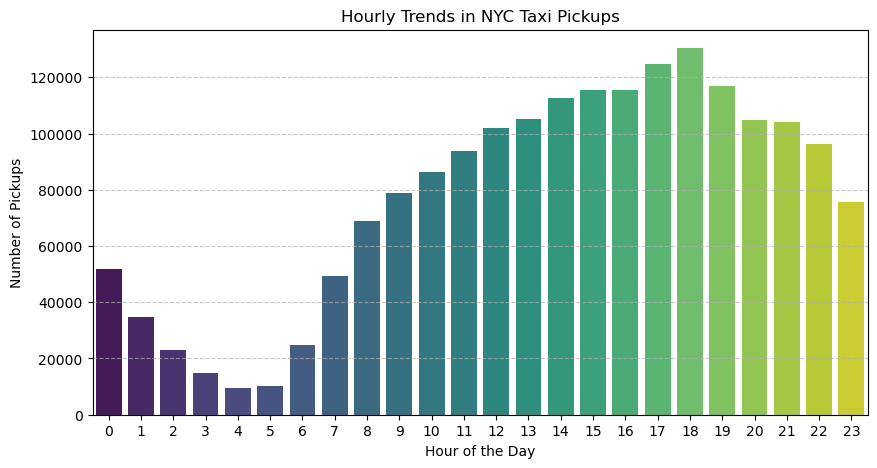

In [24]:
# Find and show the hourly trends in taxi pickups
# Extract hour, day, and month from pickup datetime
import matplotlib.pyplot as plt
import seaborn as sns
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_day'] = df['tpep_pickup_datetime'].dt.day_name()
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month_name()

# Hourly trends
hourly_counts = df.groupby('pickup_hour').size()

# Plotting hourly trends
plt.figure(figsize=(10, 5))
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, palette="viridis")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Pickups")
plt.title("Hourly Trends in NYC Taxi Pickups")
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10312\454402495.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=daily_counts.index, y=daily_counts.values, palette="viridis")


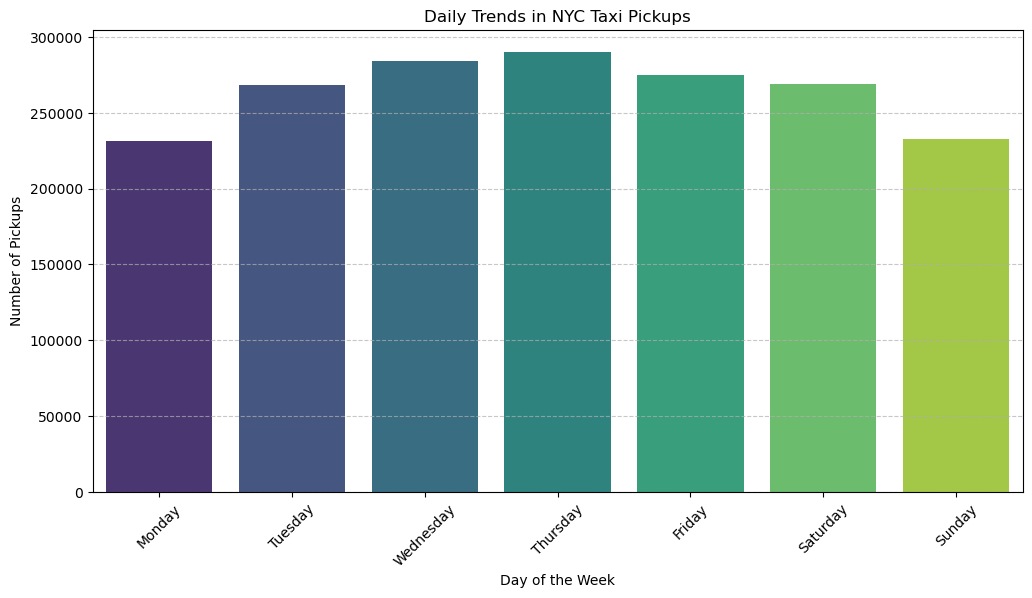

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by day of the week and get pickup counts
daily_counts = df.groupby('pickup_day').size()

# Ensure correct order of days in the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_counts = daily_counts.reindex(days_order)

# Plot daily trends
plt.figure(figsize=(12, 6))
sns.barplot(x=daily_counts.index, y=daily_counts.values, palette="viridis")

# Improve labeling for clarity
plt.xlabel("Day of the Week")
plt.ylabel("Number of Pickups")
plt.title("Daily Trends in NYC Taxi Pickups")

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add grid lines for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10312\3695893246.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_counts.index, y=monthly_counts.values, palette="viridis")


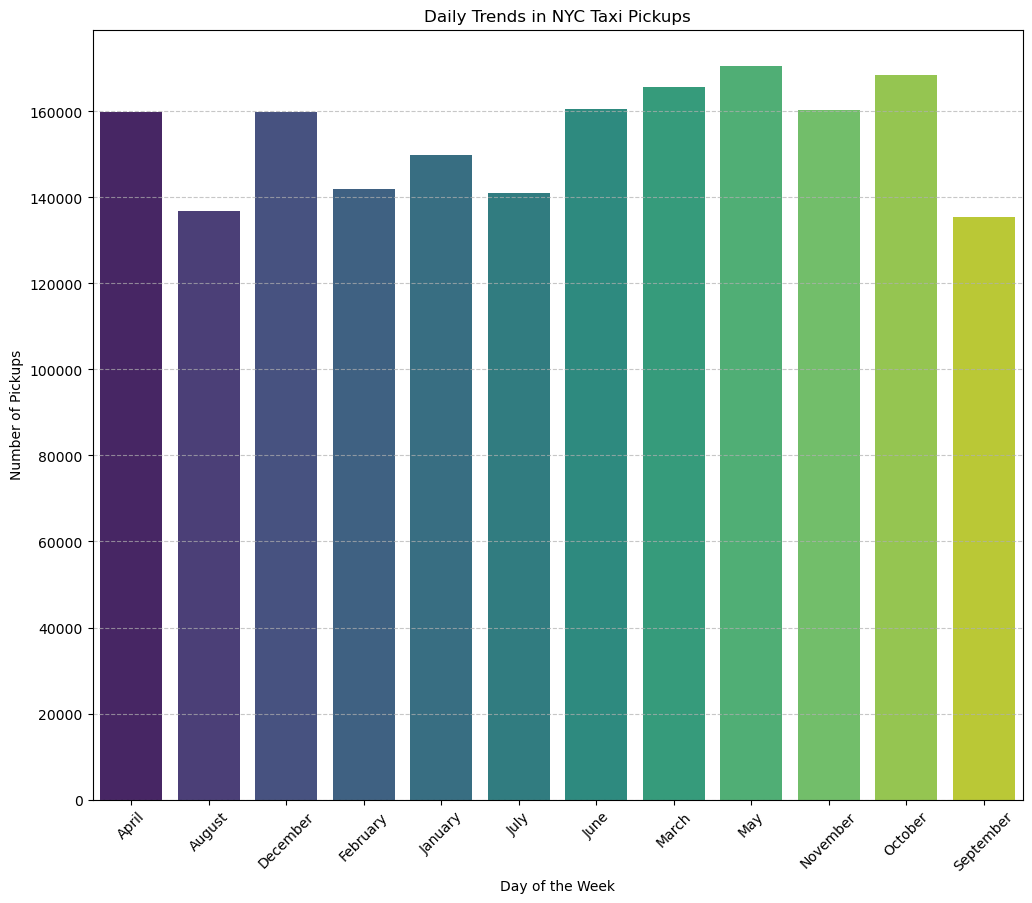

In [32]:
# Show the monthly trends in pickups

import matplotlib.pyplot as plt
import seaborn as sns

# Group by day of the week and get pickup counts
monthly_counts = df.groupby('pickup_month').size()



# Plot daily trends
plt.figure(figsize=(12, 10))
sns.barplot(x=monthly_counts.index, y=monthly_counts.values, palette="viridis")

# Improve labeling for clarity
plt.xlabel("Day of the Week")
plt.ylabel("Number of Pickups")
plt.title("Daily Trends in NYC Taxi Pickups")

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add grid lines for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [33]:
# Analyse the above parameters
# Check for zero/negative values in financial parameters
financial_cols = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']
for col in financial_cols:
    print(f"{col} <= 0:", (df[col] <= 0).sum())


fare_amount <= 0: 19303
tip_amount <= 0: 428289
total_amount <= 0: 19083
trip_distance <= 0: 25262


Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [34]:
# Create a df with non zero entries for the selected parameters.

# Create a DataFrame excluding zero fare_amount, tip_amount, and total_amount
df_non_zero = df[(df['fare_amount'] > 0) & (df['total_amount'] > 0)]

# Keep zero trip_distance if PULocationID == DOLocationID
df_non_zero = df_non_zero[~((df_non_zero['trip_distance'] == 0) & 
                            (df_non_zero['PULocationID'] != df_non_zero['DOLocationID']))]

print("Rows after filtering zeros:", len(df_non_zero))

Rows after filtering zeros: 1823334


**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10312\1369358129.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_revenue.index, y=monthly_revenue.values, palette="viridis")


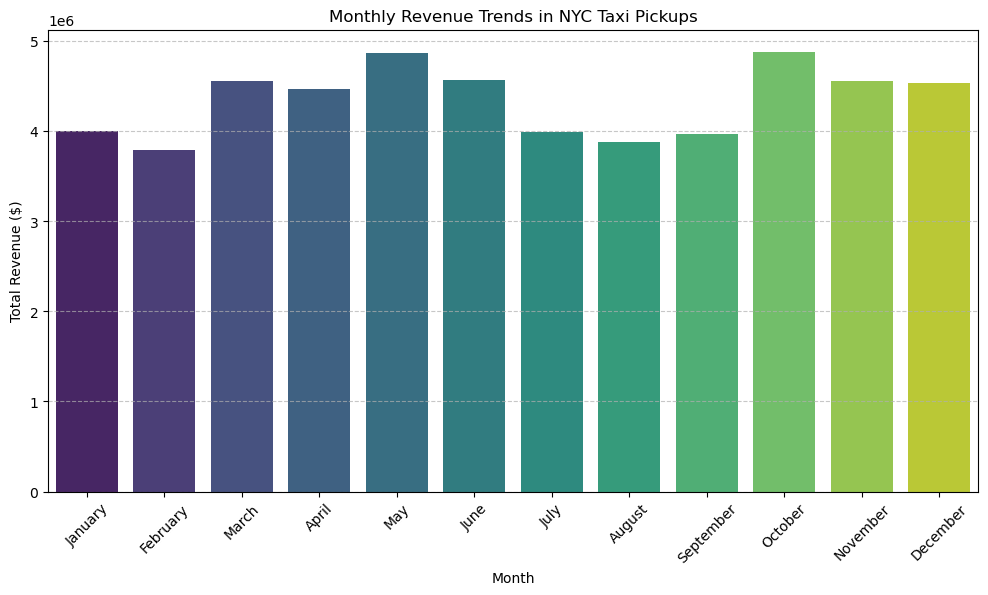

In [36]:
# Group data by month and analyse monthly revenue
# Group by month and calculate total revenue
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure months are correctly ordered
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']

# Group by month and sum total revenue
monthly_revenue = df_non_zero.groupby('pickup_month')['total_amount'].sum()

# Reorder correctly
monthly_revenue = monthly_revenue.reindex(months_order)

# Plotting monthly revenue
plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_revenue.index, y=monthly_revenue.values, palette="viridis")

# Improve labeling for clarity
plt.xlabel("Month")
plt.ylabel("Total Revenue ($)")
plt.title("Monthly Revenue Trends in NYC Taxi Pickups")

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add grid lines for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10312\2514572526.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=quarterly_proportion.index, y=quarterly_proportion.values, palette="viridis")
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10312\2514572526.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.1%}'.format(y) for y in plt.gca().get_yticks()])


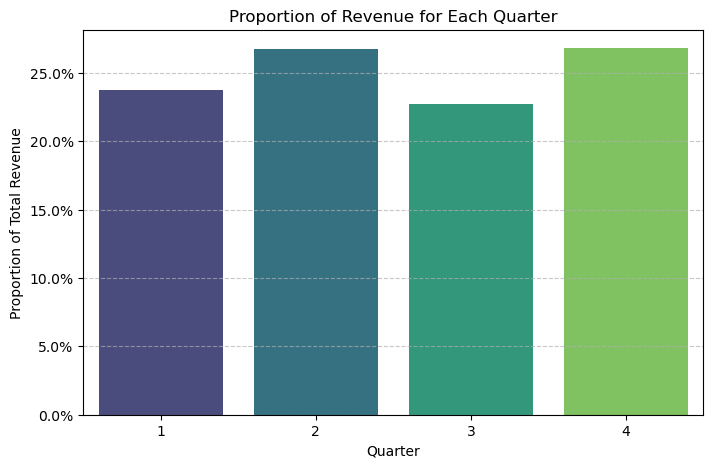

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

df_non_zero['quarter'] = df_non_zero['tpep_pickup_datetime'].dt.quarter
quarterly_revenue = df_non_zero.groupby('quarter')['total_amount'].sum()
# Calculate quarterly proportions
quarterly_proportion = quarterly_revenue / quarterly_revenue.sum()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=quarterly_proportion.index, y=quarterly_proportion.values, palette="viridis")

# Improve labeling for clarity
plt.xlabel("Quarter")
plt.ylabel("Proportion of Total Revenue")
plt.title("Proportion of Revenue for Each Quarter")

# Format y-axis to show percentage
plt.gca().set_yticklabels(['{:.1%}'.format(y) for y in plt.gca().get_yticks()])

# Add grid lines for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

Correlation between trip_distance and fare_amount: 0.94


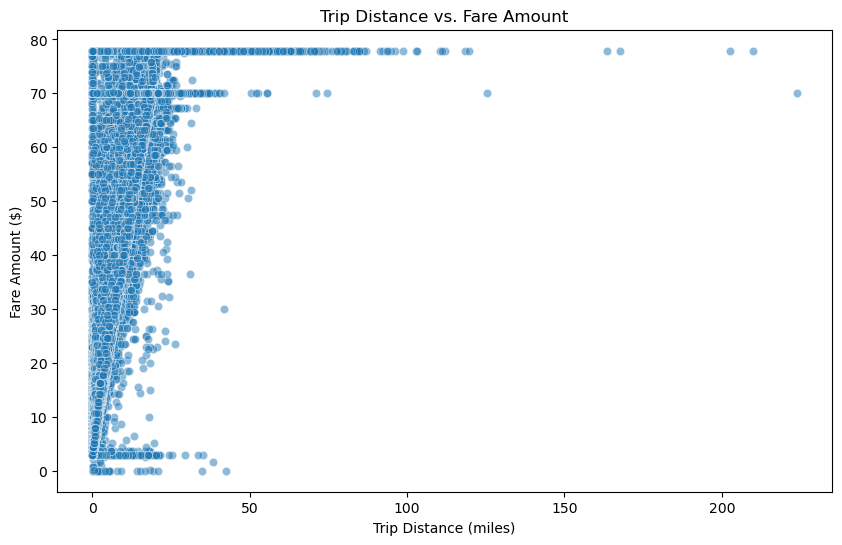

In [38]:
# Show how trip fare is affected by distance

# Filter out zero trip_distance
df_distance = df_non_zero[df_non_zero['trip_distance'] > 0]

# Calculate correlation
correlation = df_distance['trip_distance'].corr(df_distance['fare_amount'])
print(f"Correlation between trip_distance and fare_amount: {correlation:.2f}")

# Plot scatter
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='fare_amount', data=df_distance, alpha=0.5)
plt.title('Trip Distance vs. Fare Amount')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.show()

**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

Correlation between fare_amount and trip_duration: 0.28


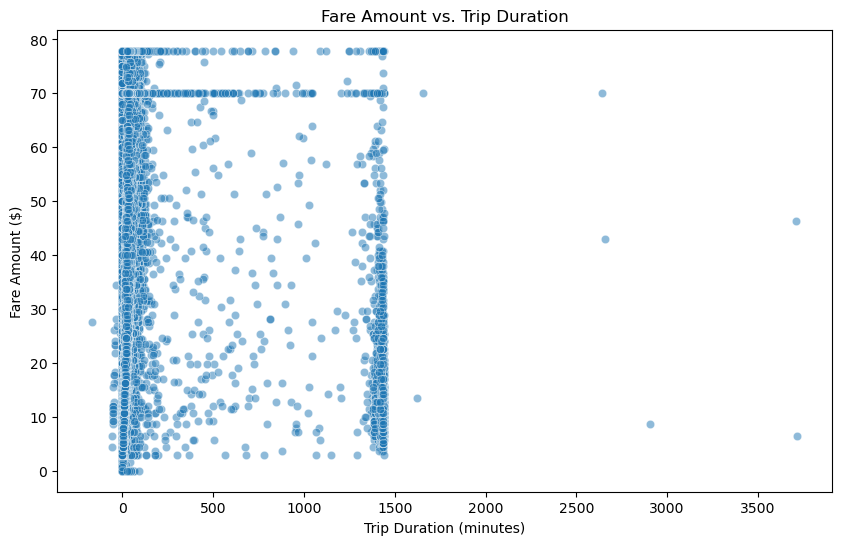

In [39]:
# Show relationship between fare and trip duration

# Calculate trip duration in minutes
df_non_zero['trip_duration'] = (df_non_zero['tpep_dropoff_datetime'] - 
                               df_non_zero['tpep_pickup_datetime']).dt.total_seconds() / 60

# 1. Fare_amount vs. trip_duration
corr_fare_duration = df_non_zero['fare_amount'].corr(df_non_zero['trip_duration'])
print(f"Correlation between fare_amount and trip_duration: {corr_fare_duration:.2f}")
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_duration', y='fare_amount', data=df_non_zero, alpha=0.5)
plt.title('Fare Amount vs. Trip Duration')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Fare Amount ($)')
plt.show()

Correlation between fare_amount and passenger_count: 0.05


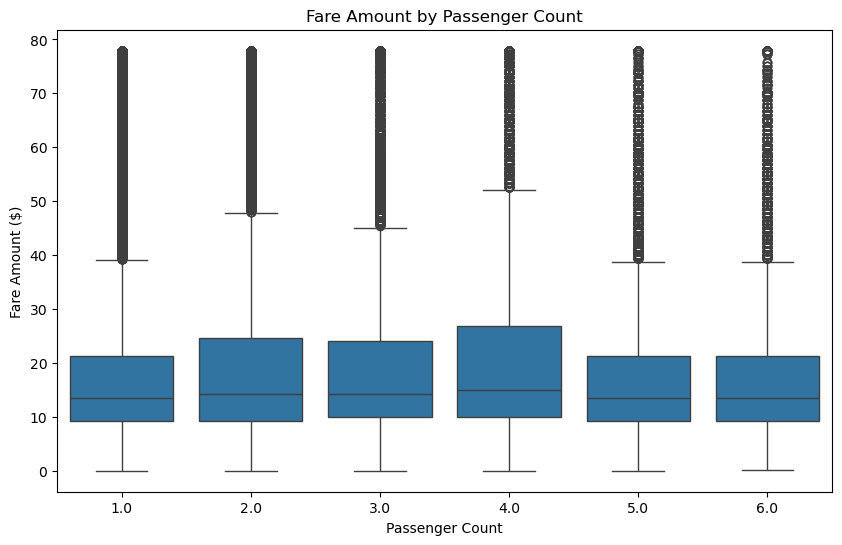

In [40]:
# Show relationship between fare and number of passengers

# 2. Fare_amount vs. passenger_count
corr_fare_passenger = df_non_zero['fare_amount'].corr(df_non_zero['passenger_count'])
print(f"Correlation between fare_amount and passenger_count: {corr_fare_passenger:.2f}")
plt.figure(figsize=(10, 6))
sns.boxplot(x='passenger_count', y='fare_amount', data=df_non_zero)
plt.title('Fare Amount by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount ($)')
plt.show()

Correlation between tip_amount and trip_distance: 0.59


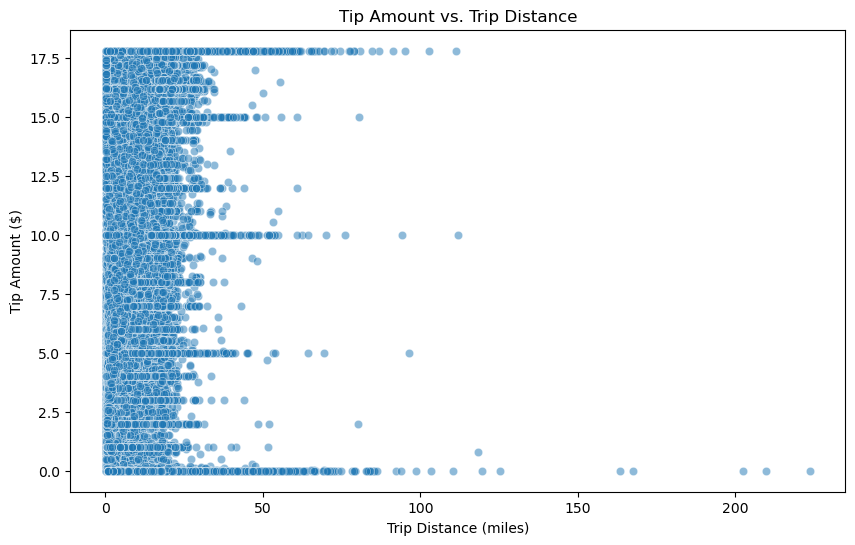

In [41]:
# Show relationship between tip and trip distance

corr_tip_distance = df_distance['tip_amount'].corr(df_distance['trip_distance'])
print(f"Correlation between tip_amount and trip_distance: {corr_tip_distance:.2f}")
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='tip_amount', data=df_distance, alpha=0.5)
plt.title('Tip Amount vs. Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Tip Amount ($)')
plt.show()

**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10312\2293236084.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=payment_counts.index, y=payment_counts.values, palette="viridis")
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10312\2293236084.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.1%}'.format(y) for y in plt.gca().get_yticks()])


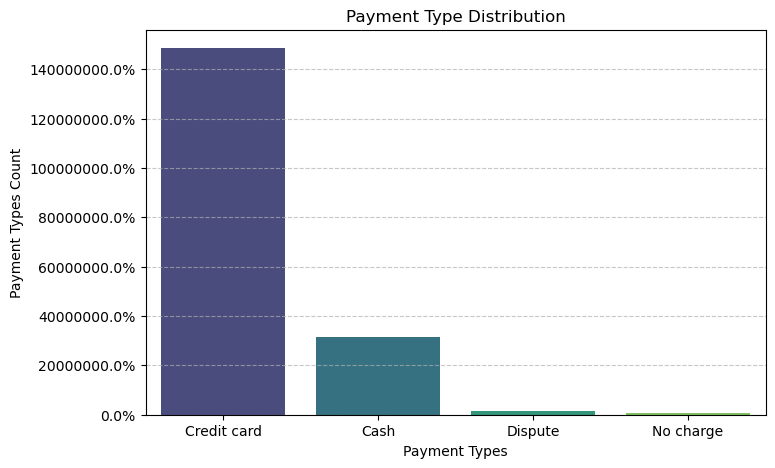

In [42]:
# Analyse the distribution of different payment types (payment_type).

# Map payment types
payment_map = {1: 'Credit card', 2: 'Cash', 3: 'No charge', 4: 'Dispute'}
df_non_zero['payment_type_desc'] = df_non_zero['payment_type'].map(payment_map)

# Count payment types
payment_counts = df_non_zero['payment_type_desc'].value_counts()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=payment_counts.index, y=payment_counts.values, palette="viridis")

# Improve labeling for clarity
plt.xlabel("Payment Types")
plt.ylabel("Payment Types Count")
plt.title("Payment Type Distribution")

# Format y-axis to show percentage
plt.gca().set_yticklabels(['{:.1%}'.format(y) for y in plt.gca().get_yticks()])

# Add grid lines for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [44]:
!pip install geopandas

Defaulting to user installation because normal site-packages is not writeable


**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

   OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...  


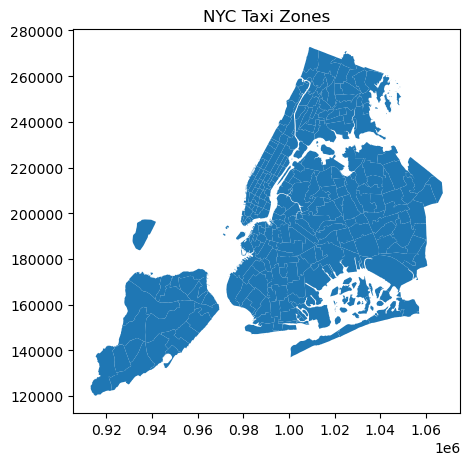

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB


In [70]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os

# Set the SHAPE_RESTORE_SHX config option as suggested in the error message


# Read the shapefile
zones = gpd.read_file('D:/EDA-Exploratary Assignments/Data/taxi_zones.shp')

# Display first few rows
print(zones.head())

# Plot the zones
zones.plot(figsize=(5, 5))
plt.title('NYC Taxi Zones')
plt.show()

zones.head()
zones.info()


Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

In [ ]:
# print(zones.info())
# zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [71]:
# Merge zones and trip records using locationID and PULocationID
# Merge zones with trip data on PULocationID
df_zones = df_non_zero.merge(zones[['LocationID', 'zone', 'borough', 'geometry']],
                             left_on='PULocationID', right_on='LocationID', how='left')

# Rename columns for clarity
df_zones = df_zones.rename(columns={'zone': 'pickup_zone', 'borough': 'pickup_borough'})

# Drop redundant LocationID
df_zones = df_zones.drop('LocationID', axis=1)

print(df_zones.head())


   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:10:30   2023-01-01 00:11:49              1.0   
1         2  2023-01-01 00:49:02   2023-01-01 00:55:15              1.0   
2         1  2023-01-01 00:47:17   2023-01-01 01:07:01              2.0   
3         2  2023-01-01 00:06:02   2023-01-01 00:31:38              1.0   
4         2  2023-01-01 00:02:19   2023-01-01 00:30:49              1.0   

   trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
0           0.49         1.0           239           238             1   
1           0.75         1.0            45           148             2   
2           2.90         1.0           142           170             1   
3           2.50         1.0            43           161             1   
4          20.37         2.0           132           140             1   

   fare_amount  ...  airport_fee  pickup_hour  pickup_day  pickup_month  \
0          4.4  ...          

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [72]:
# Group by PULocationID to count trips
trip_counts = df_zones.groupby('PULocationID').size().reset_index(name='trip_count')

print(trip_counts.head())


   PULocationID  trip_count
0             1         226
1             2           1
2             3          40
3             4        1818
4             5          16


**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [73]:
# Merge trip counts back to the zones GeoDataFrame

# Merge trip counts with zones GeoDataFrame
zones_with_trips = zones.merge(trip_counts, left_on='LocationID', right_on='PULocationID', how='left')

# Fill NaN trip counts with 0
zones_with_trips['trip_count'] = zones_with_trips['trip_count'].fillna(0)

print(zones_with_trips.head())


   OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  \
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...   
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...   
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...   
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...   
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...   

   PULocationID  trip_count  
0           1.0       226.0  
1           2.0         1.0  
2           3.0        40.

The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

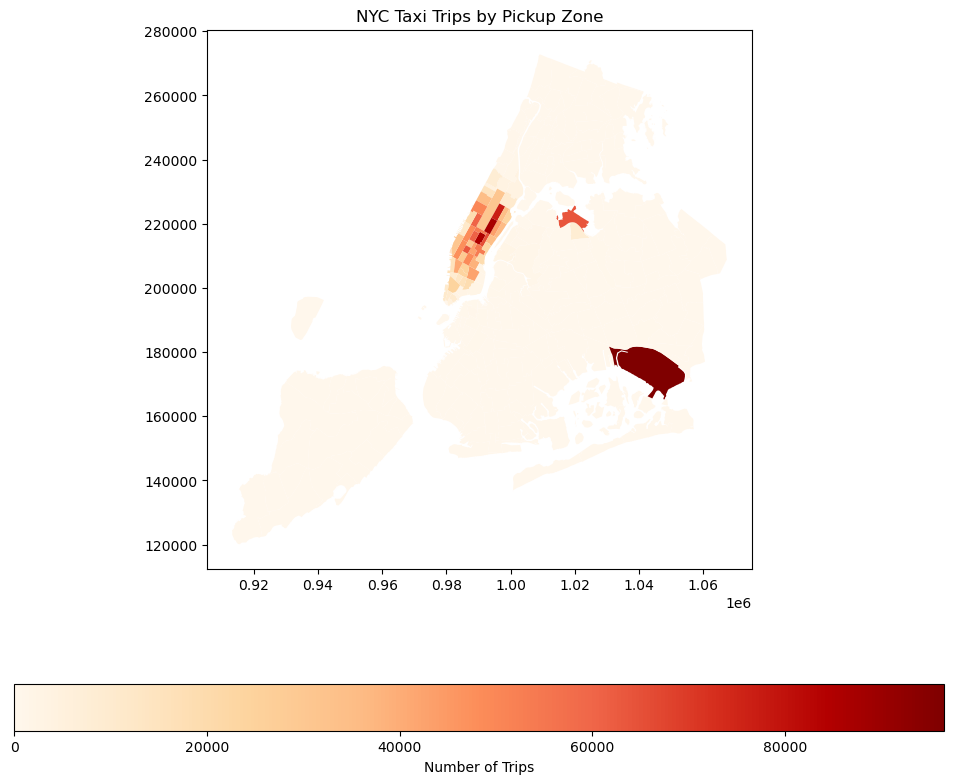

                             zone  trip_count
131                   JFK Airport     96563.0
236         Upper East Side South     86996.0
160                Midtown Center     85437.0
235         Upper East Side North     76913.0
161                  Midtown East     65353.0
137             LaGuardia Airport     64114.0
185  Penn Station/Madison Sq West     63386.0
229     Times Sq/Theatre District     60929.0
141           Lincoln Square East     60457.0
169                   Murray Hill     53793.0


In [74]:
# Define figure and axis


# Plot the map and display it
# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot choropleth map
zones_with_trips.plot(column='trip_count', ax=ax, legend=True,
                     legend_kwds={'label': "Number of Trips", 'orientation': "horizontal"},
                     cmap='OrRd')
plt.title('NYC Taxi Trips by Pickup Zone')
plt.show()

# Display zones sorted by trip count
print(zones_with_trips[['zone', 'trip_count']].sort_values(by='trip_count', ascending=False).head(10))


In [ ]:
# can you try displaying the zones DF sorted by the number of trips?



Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [75]:
# Find routes which have the slowest speeds at different times of the day
# Calculate trip duration in minutes
df_zones['trip_duration'] = (df_zones['tpep_dropoff_datetime'] - 
                            df_zones['tpep_pickup_datetime']).dt.total_seconds() / 60

# Group by pickup and dropoff zones and hour
route_speeds = df_zones[df_zones['trip_distance'] > 0].groupby(['PULocationID', 'DOLocationID', 'pickup_hour']).agg({
    'trip_distance': 'mean',
    'trip_duration': 'mean'
}).reset_index()

# Calculate speed (miles per minute)
route_speeds['speed'] = route_speeds['trip_distance'] / route_speeds['trip_duration']

# Identify slowest routes per hour
slow_routes = route_speeds.groupby('pickup_hour').apply(lambda x: x.nsmallest(5, 'speed')).reset_index(drop=True)

# Merge zone names
slow_routes = slow_routes.merge(zones[['LocationID', 'zone']], left_on='PULocationID', right_on='LocationID', how='left')
slow_routes = slow_routes.rename(columns={'zone': 'pickup_zone'})
slow_routes = slow_routes.merge(zones[['LocationID', 'zone']], left_on='DOLocationID', right_on='LocationID', how='left')
slow_routes = slow_routes.rename(columns={'zone': 'dropoff_zone'})

print("Slowest routes by hour:")
print(slow_routes[['pickup_hour', 'pickup_zone', 'dropoff_zone', 'speed']].head(20))


Slowest routes by hour:
    pickup_hour                    pickup_zone  \
0             0              Battery Park City   
1             0                Lenox Hill West   
2             0                    Boerum Hill   
3             0                       Gramercy   
4             0    Downtown Brooklyn/MetroTech   
5             1                 Central Harlem   
6             1          Upper West Side North   
7             1                    Murray Hill   
8             1                     Park Slope   
9             1                  Midtown North   
10            2        Queensbridge/Ravenswood   
11            2                       Union Sq   
12            2                           SoHo   
13            2                  Midtown North   
14            2  Sutton Place/Turtle Bay North   
15            3        Greenwich Village North   
16            3  Meatpacking/West Village West   
17            3                           SoHo   
18            3           

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10312\96332614.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slow_routes = route_speeds.groupby('pickup_hour').apply(lambda x: x.nsmallest(5, 'speed')).reset_index(drop=True)


How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10312\3470088756.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_trips.index, y=hourly_trips.values, palette="viridis")


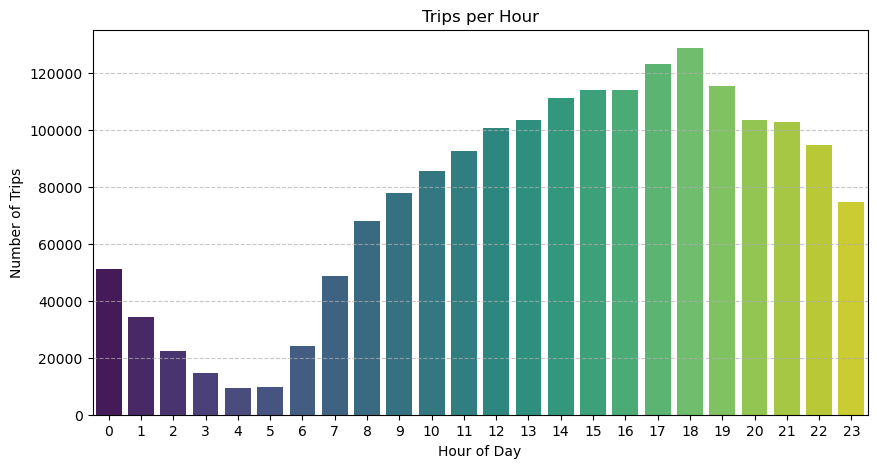

In [89]:
# Visualise the number of trips per hour and find the busiest hour
import matplotlib.pyplot as plt
import seaborn as sns

# Count trips per hour
hourly_trips = df_zones.groupby('pickup_hour').size()

# Plot the bar chart
plt.figure(figsize=(10, 5))
sns.barplot(x=hourly_trips.index, y=hourly_trips.values, palette="viridis")

# Improve labeling for clarity
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.title("Trips per Hour")

# Adjust x-axis ticks for better visibility
plt.xticks(range(0, 24))

# Add grid lines for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [92]:
# Scale up the number of trips


# Scale up trip counts
actual_trips = hourly_trips / sample_fraction
top_5_hours = actual_trips.nlargest(5)
print("Top 5 busiest hours (actual trips):")
print(top_5_hours)



Top 5 busiest hours (actual trips):
pickup_hour
18    2573640.0
17    2462100.0
19    2307180.0
15    2277480.0
16    2277260.0
dtype: float64


**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

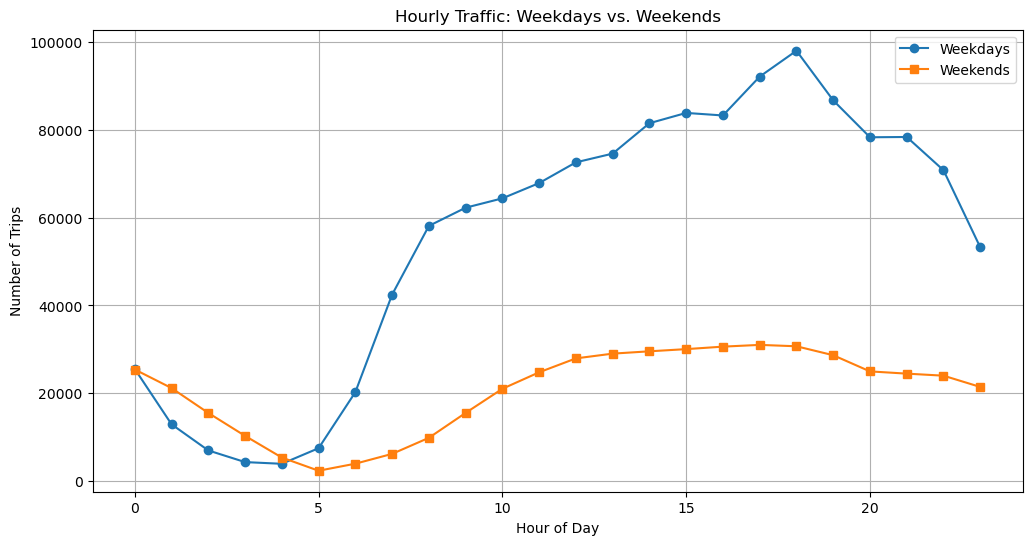

In [76]:
# Compare traffic trends for the week days and weekends

# Define weekday vs. weekend
df_zones['is_weekend'] = df_zones['pickup_day'].isin(['Saturday', 'Sunday'])

# Hourly trips by weekday/weekend
hourly_weekday = df_zones[~df_zones['is_weekend']].groupby('pickup_hour').size()
hourly_weekend = df_zones[df_zones['is_weekend']].groupby('pickup_hour').size()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(hourly_weekday.index, hourly_weekday.values, label='Weekdays', marker='o')
plt.plot(hourly_weekend.index, hourly_weekend.values, label='Weekends', marker='s')
plt.title('Hourly Traffic: Weekdays vs. Weekends')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.legend()
plt.grid(True)
plt.show()

What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

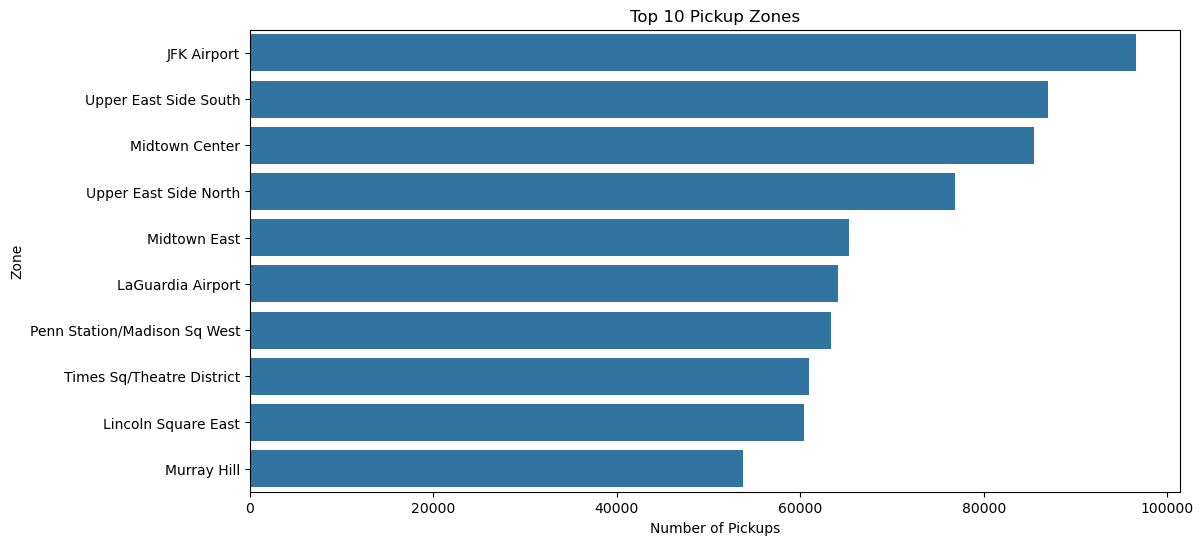

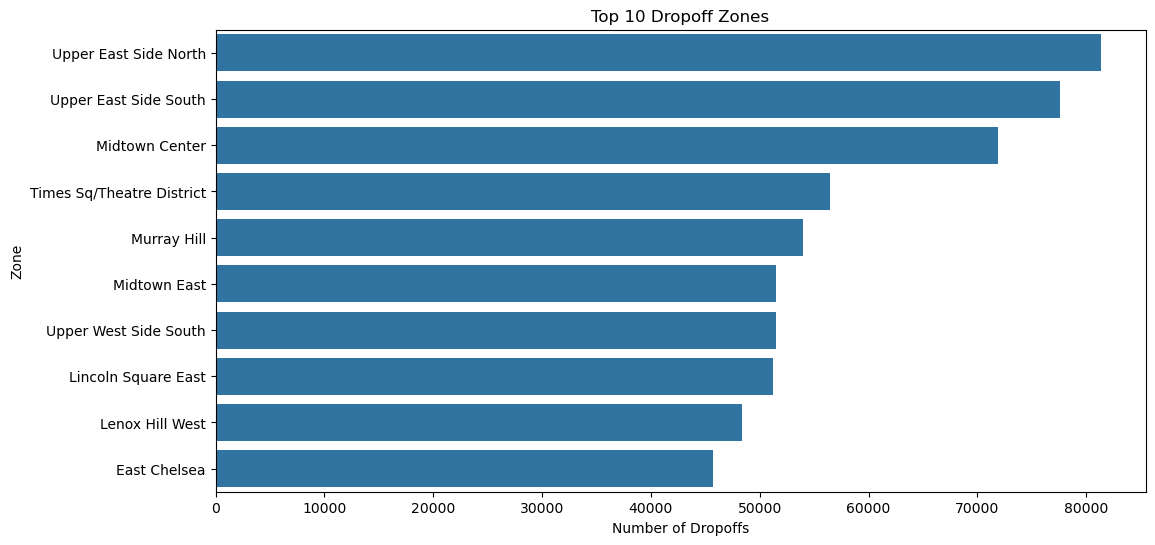

Top 10 Pickup Zones:
    PULocationID                   pickup_zone  pickup_count
0           132                   JFK Airport         96563
1           237         Upper East Side South         86996
2           161                Midtown Center         85437
3           236         Upper East Side North         76913
4           162                  Midtown East         65353
5           138             LaGuardia Airport         64114
6           186  Penn Station/Madison Sq West         63386
7           230     Times Sq/Theatre District         60929
8           142           Lincoln Square East         60457
9           170                   Murray Hill         53793
Top 10 Dropoff Zones:
    DOLocationID               dropoff_zone  dropoff_count
0           236      Upper East Side North          81385
1           237      Upper East Side South          77618
2           161             Midtown Center          71854
3           230  Times Sq/Theatre District          56485
4    

In [77]:
# Find top 10 pickup and dropoff zones

# Top 10 pickup zones
top_pickup_zones = df_zones.groupby(['PULocationID', 'pickup_zone']).size().nlargest(10).reset_index(name='pickup_count')

# Top 10 dropoff zones
df_zones = df_zones.merge(zones[['LocationID', 'zone']], left_on='DOLocationID', right_on='LocationID', how='left')
df_zones = df_zones.rename(columns={'zone': 'dropoff_zone'})
top_dropoff_zones = df_zones.groupby(['DOLocationID', 'dropoff_zone']).size().nlargest(10).reset_index(name='dropoff_count')

# Plot pickup trends
plt.figure(figsize=(12, 6))
sns.barplot(x='pickup_count', y='pickup_zone', data=top_pickup_zones)
plt.title('Top 10 Pickup Zones')
plt.xlabel('Number of Pickups')
plt.ylabel('Zone')
plt.show()

# Plot dropoff trends
plt.figure(figsize=(12, 6))
sns.barplot(x='dropoff_count', y='dropoff_zone', data=top_dropoff_zones)
plt.title('Top 10 Dropoff Zones')
plt.xlabel('Number of Dropoffs')
plt.ylabel('Zone')
plt.show()

print("Top 10 Pickup Zones:\n", top_pickup_zones)
print("Top 10 Dropoff Zones:\n", top_dropoff_zones)

**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [78]:
# Find the top 10 and bottom 10 pickup/dropoff ratios

# Calculate pickup and dropoff counts
pickup_counts = df_zones.groupby('PULocationID').size().reset_index(name='pickup_count')
dropoff_counts = df_zones.groupby('DOLocationID').size().reset_index(name='dropoff_count')

# Merge counts
ratios = pickup_counts.merge(dropoff_counts, left_on='PULocationID', right_on='DOLocationID', how='outer')
ratios['pickup_count'] = ratios['pickup_count'].fillna(0)
ratios['dropoff_count'] = ratios['dropoff_count'].fillna(0)

# Calculate ratio (avoid division by zero)
ratios['ratio'] = ratios['pickup_count'] / ratios['dropoff_count'].replace(0, 1)

# Merge zone names
ratios = ratios.merge(zones[['LocationID', 'zone']], left_on='PULocationID', right_on='LocationID', how='left')

# Top and bottom 10 ratios
top_ratios = ratios.nlargest(10, 'ratio')[['zone', 'ratio']]
bottom_ratios = ratios.nsmallest(10, 'ratio')[['zone', 'ratio']]

print("Top 10 Pickup/Dropoff Ratios:\n", top_ratios)
print("Bottom 10 Pickup/Dropoff Ratios:\n", bottom_ratios)

Top 10 Pickup/Dropoff Ratios:
                              zone     ratio
70                  East Elmhurst  8.161353
129                   JFK Airport  4.547583
135             LaGuardia Airport  2.931820
183  Penn Station/Madison Sq West  1.592869
111       Greenwich Village South  1.381464
42                   Central Park  1.357758
246                  West Village  1.337576
159                  Midtown East  1.268590
100              Garment District  1.190429
158                Midtown Center  1.189092
Bottom 10 Pickup/Dropoff Ratios:
                             zone     ratio
99                           NaN  0.000000
108                          NaN  0.000000
112                          NaN  0.000000
173                          NaN  0.000000
184                          NaN  0.000000
201                          NaN  0.000000
115  Heartland Village/Todt Hill  0.023256
203    Saint George/New Brighton  0.026316
117              Highbridge Park  0.034091
248                  

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [79]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones

# Filter nighttime hours (11 PM to 5 AM)
night_df = df_zones[df_zones['pickup_hour'].isin([23, 0, 1, 2, 3, 4])]

# Top 10 pickup and dropoff zones
night_pickup = night_df.groupby(['PULocationID', 'pickup_zone']).size().nlargest(10).reset_index(name='pickup_count')
night_dropoff = night_df.groupby(['DOLocationID', 'dropoff_zone']).size().nlargest(10).reset_index(name='dropoff_count')

print("Top 10 Nighttime Pickup Zones:\n", night_pickup)
print("Top 10 Nighttime Dropoff Zones:\n", night_dropoff)

Top 10 Nighttime Pickup Zones:
    PULocationID                   pickup_zone  pickup_count
0            79                  East Village         15294
1           132                   JFK Airport         13373
2           249                  West Village         12406
3            48                  Clinton East          9693
4           148               Lower East Side          9577
5           114       Greenwich Village South          8693
6           230     Times Sq/Theatre District          7753
7           186  Penn Station/Madison Sq West          6257
8           164                 Midtown South          6001
9           138             LaGuardia Airport          5998
Top 10 Nighttime Dropoff Zones:
    DOLocationID                   dropoff_zone  dropoff_count
0            79                   East Village           8231
1            48                   Clinton East           6857
2           170                    Murray Hill           5996
3           107            

Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [80]:
# Filter for night hours (11 PM to 5 AM)
# Nighttime revenue (11 PM to 5 AM)
night_revenue = night_df['total_amount'].sum()

# Daytime revenue (5 AM to 11 PM)
day_df = df_zones[~df_zones['pickup_hour'].isin([23, 0, 1, 2, 3, 4])]
day_revenue = day_df['total_amount'].sum()

# Proportions
total_revenue = night_revenue + day_revenue
print(f"Nighttime Revenue Share: {(night_revenue/total_revenue)*100:.2f}%")
print(f"Daytime Revenue Share: {(day_revenue/total_revenue)*100:.2f}%")


Nighttime Revenue Share: 11.36%
Daytime Revenue Share: 88.64%


##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [81]:
# Analyse the fare per mile per passenger for different passenger counts

# Calculate fare per mile
df_non_zero['fare_per_mile'] = df_non_zero['fare_amount'] / df_non_zero['trip_distance'].replace(0, 1)

# Fare per mile per passenger
df_non_zero['fare_per_mile_per_passenger'] = df_non_zero['fare_per_mile'] / df_non_zero['passenger_count']

# Group by passenger count
fare_by_passenger = df_non_zero.groupby('passenger_count')['fare_per_mile_per_passenger'].mean()

print("Average Fare per Mile per Passenger by Passenger Count:")
print(fare_by_passenger)


Average Fare per Mile per Passenger by Passenger Count:
passenger_count
1.0    10.655185
2.0     6.652047
3.0     4.328888
4.0     4.377307
5.0     1.638758
6.0     1.516815
Name: fare_per_mile_per_passenger, dtype: float64


**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

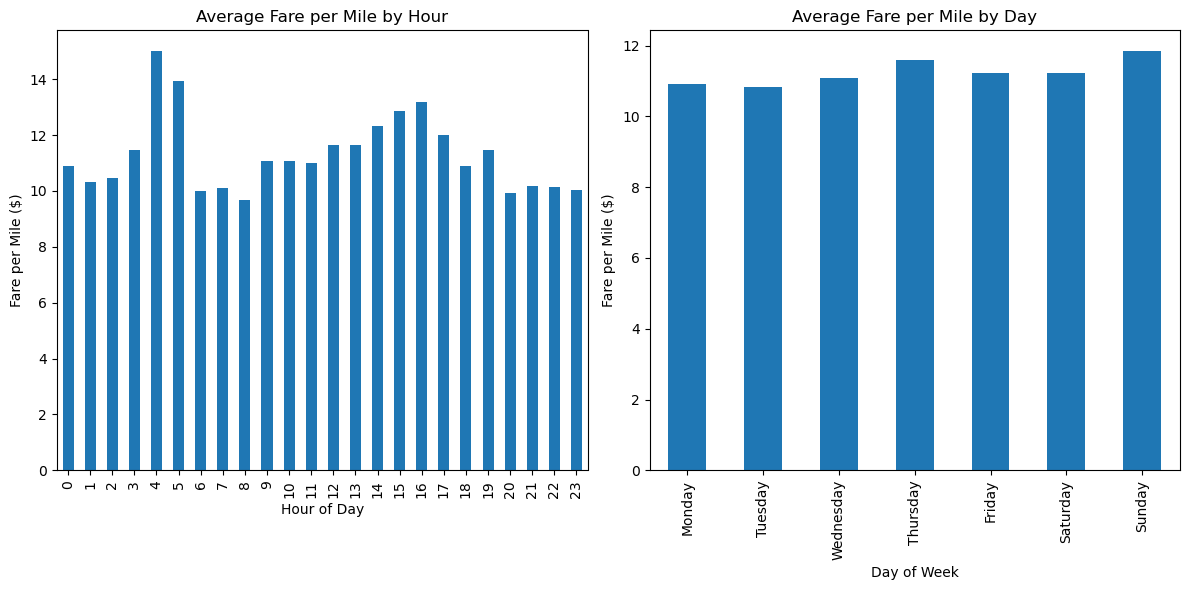

In [82]:
# Compare the average fare per mile for different days and for different times of the day

# Fare per mile by hour
fare_by_hour = df_non_zero.groupby('pickup_hour')['fare_per_mile'].mean()

# Fare per mile by day
fare_by_day = df_non_zero.groupby('pickup_day')['fare_per_mile'].mean().reindex(days_order)

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
fare_by_hour.plot(kind='bar')
plt.title('Average Fare per Mile by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Fare per Mile ($)')

plt.subplot(1, 2, 2)
fare_by_day.plot(kind='bar')
plt.title('Average Fare per Mile by Day')
plt.xlabel('Day of Week')
plt.ylabel('Fare per Mile ($)')
plt.tight_layout()
plt.show()

**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

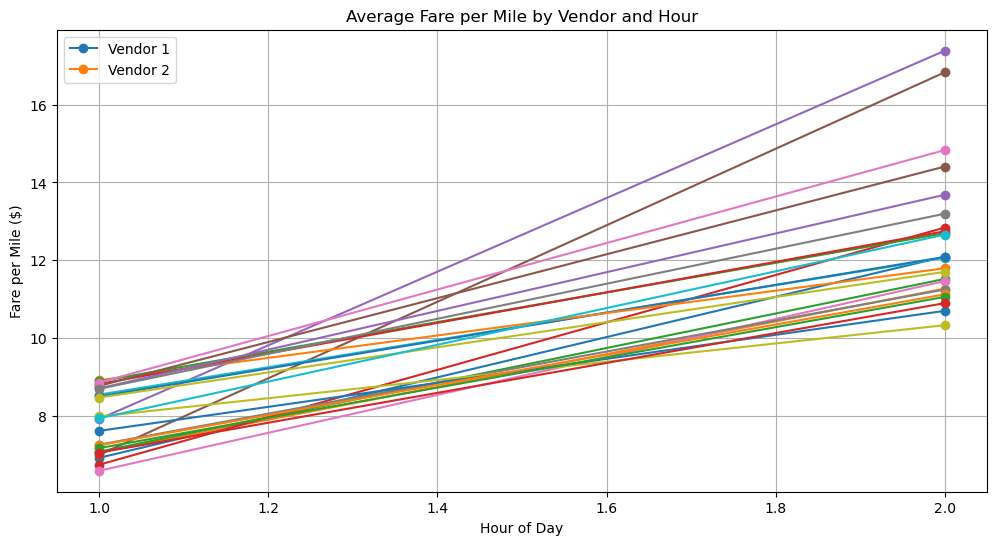

In [83]:
# Compare fare per mile for different vendors

# Fare per mile by vendor and hour
fare_by_vendor_hour = df_non_zero.groupby(['VendorID', 'pickup_hour'])['fare_per_mile'].mean().unstack()

# Plot
fare_by_vendor_hour.plot(figsize=(12, 6), marker='o')
plt.title('Average Fare per Mile by Vendor and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Fare per Mile ($)')
plt.legend(['Vendor 1', 'Vendor 2'])
plt.grid(True)
plt.show()

**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10312\4046593332.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fare_by_tier_vendor = df_non_zero.groupby(['distance_tier', 'VendorID'])['fare_per_mile'].mean().unstack()


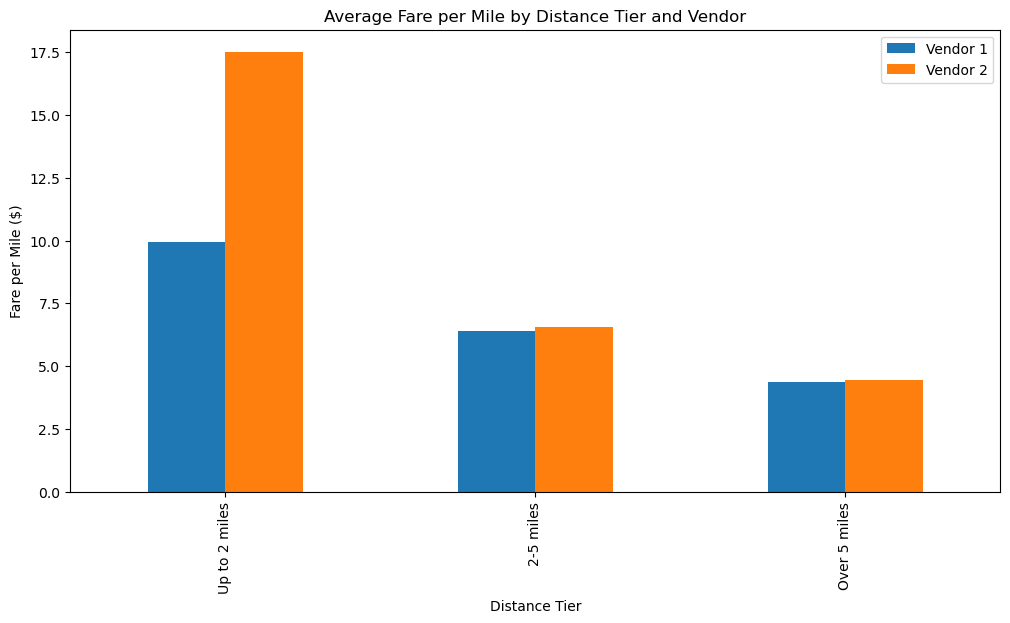

In [84]:
# Defining distance tiers

# Define distance tiers
df_non_zero['distance_tier'] = pd.cut(df_non_zero['trip_distance'],
                                     bins=[0, 2, 5, float('inf')],
                                     labels=['Up to 2 miles', '2-5 miles', 'Over 5 miles'])

# Fare per mile by vendor and tier
fare_by_tier_vendor = df_non_zero.groupby(['distance_tier', 'VendorID'])['fare_per_mile'].mean().unstack()

# Plot
fare_by_tier_vendor.plot(kind='bar', figsize=(12, 6))
plt.title('Average Fare per Mile by Distance Tier and Vendor')
plt.xlabel('Distance Tier')
plt.ylabel('Fare per Mile ($)')
plt.legend(['Vendor 1', 'Vendor 2'])
plt.show()

##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10312\3121861404.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tip_by_distance = df_non_zero.groupby(pd.cut(df_non_zero['trip_distance'], bins=5))['tip_percentage'].mean()


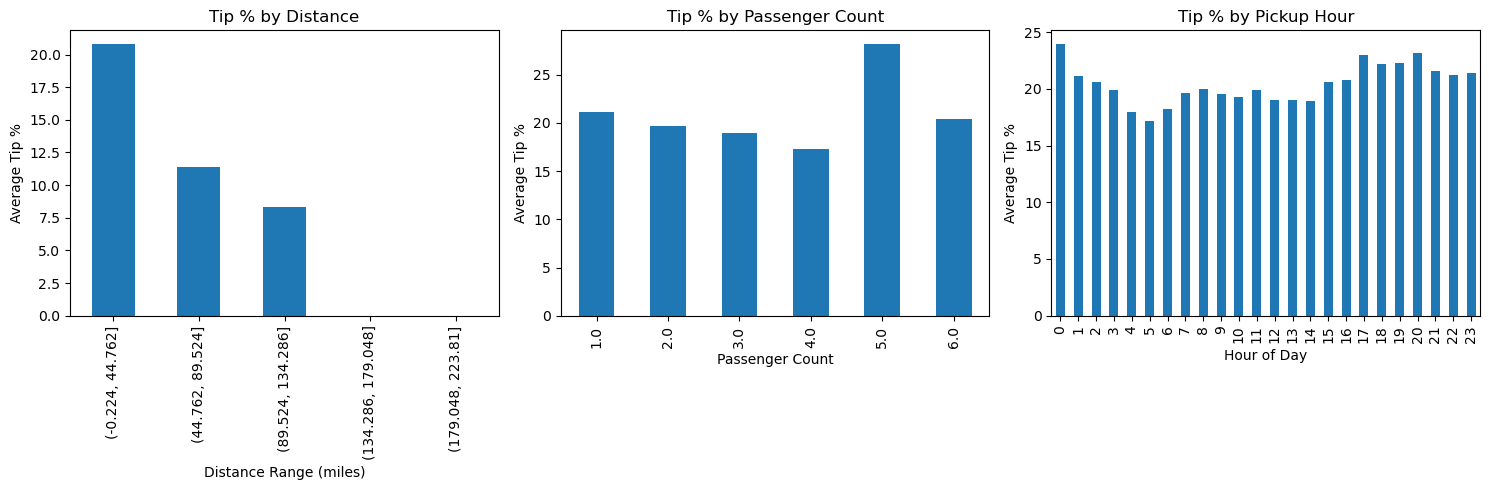

Factors for low tips (<10%):
       trip_distance  passenger_count    pickup_hour
count  480673.000000    480673.000000  480673.000000
mean        3.805624         1.428522      13.922748
std         5.088542         0.909648       5.730118
min         0.000000         1.000000       0.000000
25%         1.010000         1.000000      10.000000
50%         1.830000         1.000000      14.000000
75%         3.900000         2.000000      18.000000
max       223.810000         6.000000      23.000000


In [85]:
#  Analyze tip percentages based on distances, passenger counts and pickup times
# Calculate tip percentage
df_non_zero['tip_percentage'] = (df_non_zero['tip_amount'] / df_non_zero['fare_amount'] * 100).replace([np.inf, -np.inf], 0)

# Analyze by distance, passenger count, and pickup hour
tip_by_distance = df_non_zero.groupby(pd.cut(df_non_zero['trip_distance'], bins=5))['tip_percentage'].mean()
tip_by_passenger = df_non_zero.groupby('passenger_count')['tip_percentage'].mean()
tip_by_hour = df_non_zero.groupby('pickup_hour')['tip_percentage'].mean()

# Plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
tip_by_distance.plot(kind='bar')
plt.title('Tip % by Distance')
plt.xlabel('Distance Range (miles)')
plt.ylabel('Average Tip %')

plt.subplot(1, 3, 2)
tip_by_passenger.plot(kind='bar')
plt.title('Tip % by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Average Tip %')

plt.subplot(1, 3, 3)
tip_by_hour.plot(kind='bar')
plt.title('Tip % by Pickup Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Tip %')
plt.tight_layout()
plt.show()

# Low tip factors (<10%)
low_tip = df_non_zero[df_non_zero['tip_percentage'] < 10]
print("Factors for low tips (<10%):")
print(low_tip[['trip_distance', 'passenger_count', 'pickup_hour']].describe())


Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

In [ ]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%



**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

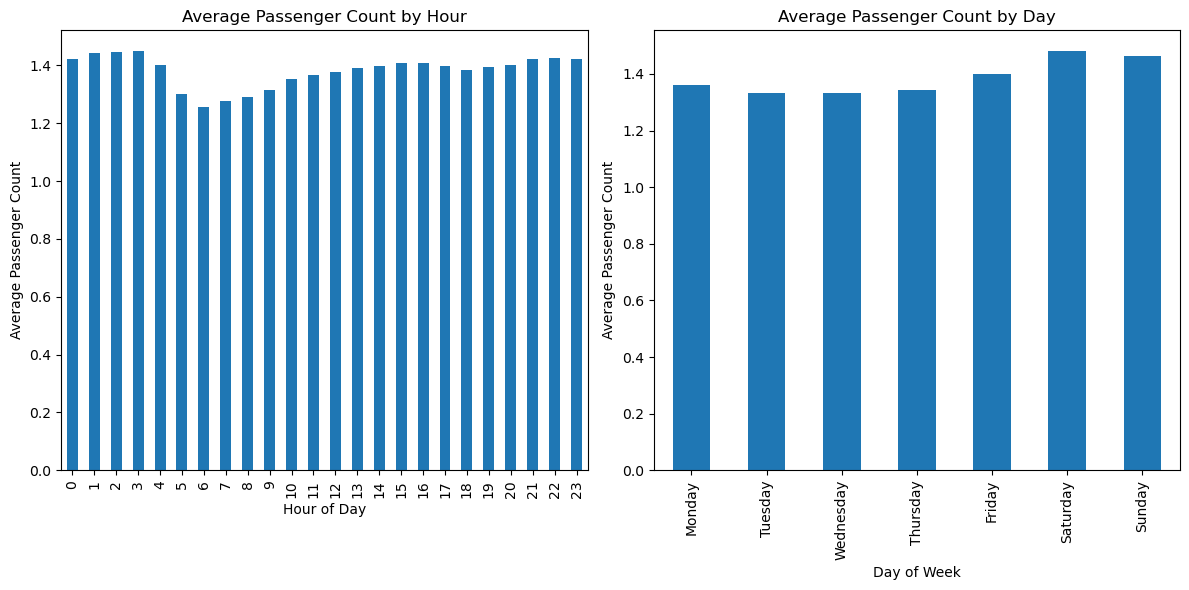

In [86]:
# See how passenger count varies across hours and days


# Passenger count by hour and day
passenger_by_hour = df_non_zero.groupby('pickup_hour')['passenger_count'].mean()
passenger_by_day = df_non_zero.groupby('pickup_day')['passenger_count'].mean().reindex(days_order)

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
passenger_by_hour.plot(kind='bar')
plt.title('Average Passenger Count by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Passenger Count')

plt.subplot(1, 2, 2)
passenger_by_day.plot(kind='bar')
plt.title('Average Passenger Count by Day')
plt.xlabel('Day of Week')
plt.ylabel('Average Passenger Count')
plt.tight_layout()
plt.show()

**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

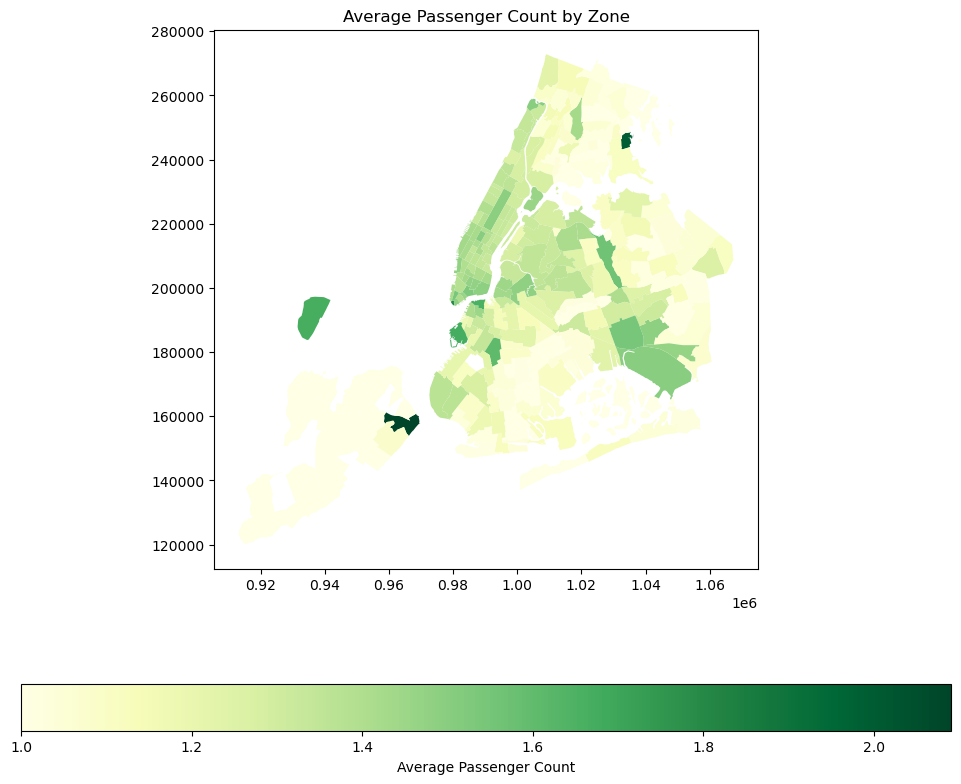

In [87]:
# How does passenger count vary across zones

# Average passenger count by pickup zone
passenger_by_zone = df_zones.groupby(['PULocationID', 'pickup_zone'])['passenger_count'].mean().reset_index()

# Merge with GeoDataFrame
zones_with_passengers = zones_with_trips.merge(passenger_by_zone[['PULocationID', 'passenger_count']],
                                              left_on='LocationID', right_on='PULocationID', how='left')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
zones_with_passengers.plot(column='passenger_count', ax=ax, legend=True,
                           legend_kwds={'label': "Average Passenger Count", 'orientation': "horizontal"},
                           cmap='YlGn')
plt.title('Average Passenger Count by Zone')
plt.show()

In [ ]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.



Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [88]:
# How often is each surcharge applied?

# Check surcharge applications
surcharges = ['extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'airport_fee']
for surcharge in surcharges:
    if surcharge in df_zones.columns:
        applied = (df_zones[surcharge] > 0).sum()
        print(f"{surcharge} applied in {applied} trips ({applied/len(df_zones)*100:.2f}%)")

# Surcharges by zone and hour
for surcharge in surcharges:
    if surcharge in df_zones.columns:
        surcharge_by_zone = df_zones[df_zones[surcharge] > 0].groupby('pickup_zone').size()
        surcharge_by_hour = df_zones[df_zones[surcharge] > 0].groupby('pickup_hour').size()
        print(f"\nTop 5 zones for {surcharge}:\n", surcharge_by_zone.nlargest(5))
        print(f"Top 5 hours for {surcharge}:\n", surcharge_by_hour.nlargest(5))

extra applied in 1131077 trips (62.01%)
mta_tax applied in 1807609 trips (99.11%)
improvement_surcharge applied in 1823782 trips (99.99%)
congestion_surcharge applied in 1685835 trips (92.43%)
airport_fee applied in 160912 trips (8.82%)

Top 5 zones for extra:
 pickup_zone
LaGuardia Airport        63419
Midtown Center           54847
Upper East Side South    50181
JFK Airport              48118
Upper East Side North    40694
dtype: int64
Top 5 hours for extra:
 pickup_hour
18    103834
21     99423
17     98389
20     98382
19     92261
dtype: int64

Top 5 zones for mta_tax:
 pickup_zone
JFK Airport              94673
Upper East Side South    86805
Midtown Center           84753
Upper East Side North    76749
Midtown East             64925
dtype: int64
Top 5 hours for mta_tax:
 pickup_hour
18    127887
17    122158
19    114643
16    112714
15    112656
dtype: int64

Top 5 zones for improvement_surcharge:
 pickup_zone
JFK Airport              96708
Upper East Side South    86995
Midtow

## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

In [ ]:
Peak Hour Dispatching: Increase driver availability during peak hours (5PM-7PM)
Slow Route Avoidance: 
Midnight (0:00 - 1:00): Battery Park City and Lenox Hill West experience slower traffic, likely due to quiet residential streets and minimal movement at night.
Early Morning (1:00 - 3:00): Central Harlem and Midtown North see reduced speeds, influenced by stop-and-go pedestrian activity and high-density intersections

Zone-Based Dispatching: 
Night time :East Village has high pickup zone and also high time drop off zones
Nighttime Operations: Allocate more cabs to nightlife zones (from 3.2.7) like Lower East Side from 11 PM to 5 AM to capture high-demand trips.


**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

In [ ]:

JFK airport,UPper East side South ,Midtown center are high pickup zones, Cabs should be more allocated to these areas
weekends more traffic is in between 15-20 hours and cabs demand is during this period of time in weekends

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

In [ ]:
Increase fares during peak hours and in high-demand zones  to maximize revenue, as fares per mile are higher during congestion.
Implement tiered pricing based on distance , with higher rates for short trips (<2 miles) to cover fixed costs, and competitive rates for longer trips to match Vendor 2’s pricing.
                                                                                                                                     Offer slight discounts for higher passenger counts to encourage group travel, as fare per mile per passenger decreases with more passengers.